In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

Training_Dataset = r"C:\Users\hruth\OneDrive\Desktop\PlantVillage"
dataset = tf.keras.utils.image_dataset_from_directory(
    Training_Dataset,
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
) 

Found 2152 files belonging to 3 classes.


In [3]:
# DATASET AVAILABLE:
#  80% ==> Training
#  20% ==> 10% - Validation, 10% - Testing

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) 

68

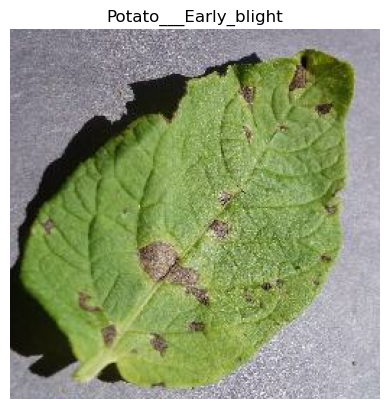

In [6]:
#Testing Purpose
for image_batch, label_batch in dataset.take(1):          
    plt.imshow(image_batch[0].numpy().astype("uint8"))    
    #plt.figure(figsize=(0.1, .1))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
    #print(label_batch[0])

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) #seed can be anything
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
#PRE-PROCESSING:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#.cache(): using this, the dataset is stored in the cache for the first epoch. This way no need to reload it in next epoch
#shuffle(1000): shuffles the first 1000 samples
#prefetch(buffer_size=tf.data.AUTOTUNE): allows subsequent batches to be prepared while the current batch is being processed. Improves effeciency
#all of the above can optimise the training making it much faster

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
#Scaling the images b/w 0 and 1
#Resizing it so in occurence of image not being 256x256, it can resize 
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1.0/255)
]) 

In [11]:
#Data-Augmentation - New training samples made from existing with different rotations and saturations etc
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])

In [12]:
#Building CNN:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)), 

    #Stacking more layers:
    layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),                      # moving from feature extraction to decision-making
    layers.Dense(64, activation='relu'),   
    layers.Dense(3, activation='softmax')  #softmax converts scores into probabilities ensuring they sum up to 1 
])

model.build(input_shape=input_shape)

C:\Users\hruth\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #y is a value so sparse used
              metrics=['accuracy'])

model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4513 - loss: 0.9470 - val_accuracy: 0.4115 - val_loss: 0.9668
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 932ms/step - accuracy: 0.6105 - loss: 0.7832 - val_accuracy: 0.6979 - val_loss: 0.6539
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 839ms/step - accuracy: 0.8038 - loss: 0.4649 - val_accuracy: 0.8490 - val_loss: 0.3842
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 824ms/step - accuracy: 0.8003 - loss: 0.4176 - val_accuracy: 0.8906 - val_loss: 0.3236
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 823ms/step - accuracy: 0.8589 - loss: 0.3090 - val_accuracy: 0.9010 - val_loss: 0.2223
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 906ms/step - accuracy: 0.8912 - loss: 0.2670 - val_accuracy: 0.8854 - val_loss: 0.2887
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.9166 - loss: 0.2396 - val_accuracy: 0.9427 - val_loss: 0.1509
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 825ms/step - accuracy: 0.9255 - loss: 0.2031 - val_accurac

In [15]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.9314 - loss: 0.1771


In [16]:
scores

[0.15133237838745117, 0.9296875]

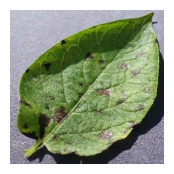

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Image 1:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




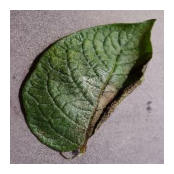

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image 2:
Actual Label: Potato___Late_blight
Predicted Label: Potato___Late_blight




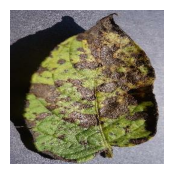

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Image 3:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




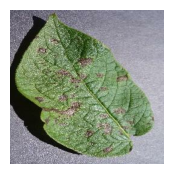

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Image 4:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




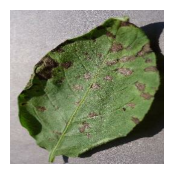

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image 5:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




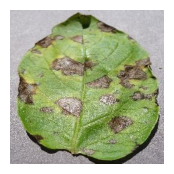

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image 6:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




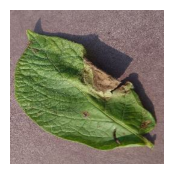

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image 7:
Actual Label: Potato___Late_blight
Predicted Label: Potato___Late_blight




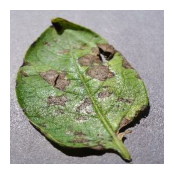

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image 8:
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight




In [17]:
#CHECKING THE PREDICTION:

import numpy as np

for images_batch, labels_batch in test_ds.take(1):  
    for i in range(8):  
        image = images_batch[i].numpy().astype("uint8")
        label = labels_batch[i].numpy()

        # Display the image
        plt.figure(figsize=(2, 2))
        plt.imshow(image)
        #plt.title(f"Actual: {class_names[label]}")
        plt.axis("off")
        plt.show()

        # Predict and print the label
        batch_prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_label = class_names[np.argmax(batch_prediction[0])]
        #confidence = round(100*(np.max(batch_prediction[0])), 2)
        
        print(f"Image {i+1}:")
        print("Actual Label:", class_names[label])
        print("Predicted Label:", predicted_label)
        #print("Confidence:", confidence)
        print("\n")  


In [40]:
model_version = 1
filepath = f"../Model/model_{model_version}.keras"

model.save(filepath)
